# Predictive Maintenance

## Dataset 1 - Regression (RUL) using Kalman Filter + LSTM

In [0]:
!pip install pykalman
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

import keras
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, Embedding

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
%matplotlib inline

## Preprocess Train and Test Data using Kalman Filtering

In [0]:
# read training data 
train_df = pd.read_csv('train_01.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [0]:
for cols in train_df.columns:
    if cols == 'id':
        continue;
    if cols == 'cycle':
        continue;
    else:
        kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = train_df[cols].values[0],
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)
        state_means,_ = kf.filter(train_df[cols].values)
        train_df[cols] = state_means.flatten()

In [0]:
# read test data
test_df = pd.read_csv('test_01.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [0]:
for cols in test_df.columns:
    if cols == 'id':
        continue;
    if cols == 'cycle':
        continue;
    else:
        kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = test_df[cols].values[0],
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)
        state_means,_ = kf.filter(test_df[cols].values)
        test_df[cols] = state_means.flatten()

In [0]:
# read ground truth data
truth_df = pd.read_csv('truth_01.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [0]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.000700,-0.000400,100.0,518.67,641.820000,1589.700000,1400.600000,14.62,21.61,554.360000,2388.060000,9046.190000,1.3,47.470000,521.660000,2388.020000,8138.620000,8.419500,0.03,392.000000,2388.0,100.0,39.060000,23.419000
1,1,2,0.000178,-0.000366,100.0,518.67,641.931457,1590.416026,1401.457881,14.62,21.61,554.153974,2388.053245,9045.473974,1.3,47.476755,521.869404,2388.036887,8136.211854,8.423654,0.03,392.000000,2388.0,100.0,39.039735,23.420554
2,1,3,-0.000977,-0.000194,100.0,518.67,642.039450,1589.790059,1402.165407,14.62,21.61,554.181331,2388.060148,9047.400370,1.3,47.423408,522.011470,2388.035110,8135.442471,8.422144,0.03,391.483957,2388.0,100.0,39.016581,23.400853
3,1,4,-0.000623,-0.000153,100.0,518.67,642.105091,1588.310457,1402.102967,14.62,21.61,554.238119,2388.070686,9047.839942,1.3,47.361390,522.190824,2388.044599,8135.101643,8.410742,0.03,391.593033,2388.0,100.0,38.987712,23.395156
4,1,5,-0.000854,-0.000162,100.0,518.67,642.153105,1587.320764,1402.849168,14.62,21.61,554.194961,2388.068749,9049.164870,1.3,47.346638,522.190674,2388.043765,8134.865724,8.414123,0.03,391.848042,2388.0,100.0,38.971815,23.396831


## Generate True Values for Train Data

In [0]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.000700,-0.000400,100.0,518.67,641.820000,1589.700000,1400.600000,14.62,21.61,554.360000,2388.060000,9046.190000,1.3,47.470000,521.660000,2388.020000,8138.620000,8.419500,0.03,392.000000,2388.0,100.0,39.060000,23.419000,191
1,1,2,0.000178,-0.000366,100.0,518.67,641.931457,1590.416026,1401.457881,14.62,21.61,554.153974,2388.053245,9045.473974,1.3,47.476755,521.869404,2388.036887,8136.211854,8.423654,0.03,392.000000,2388.0,100.0,39.039735,23.420554,190
2,1,3,-0.000977,-0.000194,100.0,518.67,642.039450,1589.790059,1402.165407,14.62,21.61,554.181331,2388.060148,9047.400370,1.3,47.423408,522.011470,2388.035110,8135.442471,8.422144,0.03,391.483957,2388.0,100.0,39.016581,23.400853,189
3,1,4,-0.000623,-0.000153,100.0,518.67,642.105091,1588.310457,1402.102967,14.62,21.61,554.238119,2388.070686,9047.839942,1.3,47.361390,522.190824,2388.044599,8135.101643,8.410742,0.03,391.593033,2388.0,100.0,38.987712,23.395156,188
4,1,5,-0.000854,-0.000162,100.0,518.67,642.153105,1587.320764,1402.849168,14.62,21.61,554.194961,2388.068749,9049.164870,1.3,47.346638,522.190674,2388.043765,8134.865724,8.414123,0.03,391.848042,2388.0,100.0,38.971815,23.396831,187


In [0]:
# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.000700,-0.000400,100.0,518.67,641.820000,1589.700000,1400.600000,14.62,21.61,554.360000,2388.060000,9046.190000,1.3,47.470000,521.660000,2388.020000,8138.620000,8.419500,0.03,392.000000,2388.0,100.0,39.060000,23.419000,191,0,0
1,1,2,0.000178,-0.000366,100.0,518.67,641.931457,1590.416026,1401.457881,14.62,21.61,554.153974,2388.053245,9045.473974,1.3,47.476755,521.869404,2388.036887,8136.211854,8.423654,0.03,392.000000,2388.0,100.0,39.039735,23.420554,190,0,0
2,1,3,-0.000977,-0.000194,100.0,518.67,642.039450,1589.790059,1402.165407,14.62,21.61,554.181331,2388.060148,9047.400370,1.3,47.423408,522.011470,2388.035110,8135.442471,8.422144,0.03,391.483957,2388.0,100.0,39.016581,23.400853,189,0,0
3,1,4,-0.000623,-0.000153,100.0,518.67,642.105091,1588.310457,1402.102967,14.62,21.61,554.238119,2388.070686,9047.839942,1.3,47.361390,522.190824,2388.044599,8135.101643,8.410742,0.03,391.593033,2388.0,100.0,38.987712,23.395156,188,0,0
4,1,5,-0.000854,-0.000162,100.0,518.67,642.153105,1587.320764,1402.849168,14.62,21.61,554.194961,2388.068749,9049.164870,1.3,47.346638,522.190674,2388.043765,8134.865724,8.414123,0.03,391.848042,2388.0,100.0,38.971815,23.396831,187,0,0


## Normalize Train and Test Data

In [0]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.368542,0.000000,0.0,0.0,0.000000,0.349894,0.185846,0.0,1.0,0.878722,0.242639,0.091191,0.0,0.356551,0.685441,0.131931,0.207883,0.265399,0.0,0.184954,0.0,0.0,0.938255,0.901462,191,0,0,0.00000
1,1,2,0.606362,0.045503,0.0,0.0,0.058599,0.381941,0.211315,0.0,1.0,0.818707,0.220732,0.086909,0.0,0.363140,0.757866,0.184063,0.191990,0.295538,0.0,0.184954,0.0,0.0,0.907757,0.905421,190,0,0,0.00277
2,1,3,0.293440,0.277092,0.0,0.0,0.115377,0.353925,0.232320,0.0,1.0,0.826676,0.243121,0.098430,0.0,0.311104,0.807002,0.178577,0.186913,0.284579,0.0,0.092264,0.0,0.0,0.872911,0.855227,189,0,0,0.00554
3,1,4,0.389455,0.332429,0.0,0.0,0.149888,0.287703,0.230467,0.0,1.0,0.843218,0.277295,0.101059,0.0,0.250610,0.869034,0.207868,0.184663,0.201857,0.0,0.111856,0.0,0.0,0.829464,0.840712,188,0,0,0.00831
4,1,5,0.326762,0.321014,0.0,0.0,0.175131,0.243408,0.252620,0.0,1.0,0.830646,0.271014,0.108983,0.0,0.236221,0.868982,0.205295,0.183106,0.226392,0.0,0.157660,0.0,0.0,0.805538,0.844981,187,0,0,0.01108


In [0]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,1.181006,0.943062,0.0,0.0,0.630905,0.152518,0.114891,0.0,1.0,0.744724,0.177775,0.114995,0.0,0.093186,0.706193,0.162801,0.121627,0.161653,0.0,0.184954,0.0,0.0,0.637261,0.785538,0.00000
1,1,2,0.723659,0.670047,0.0,0.0,0.398285,0.200286,0.086915,0.0,1.0,0.838191,0.144913,0.123580,0.0,0.192020,0.757592,0.194081,0.152988,0.100639,0.0,0.245620,0.0,0.0,0.718589,0.801113,0.00277
2,1,3,0.701909,0.670968,0.0,0.0,0.382339,0.207015,0.118110,0.0,1.0,0.829858,0.161760,0.131843,0.0,0.242023,0.766640,0.186010,0.152644,0.189200,0.0,0.276312,0.0,0.0,0.783034,0.825428,0.00554
3,1,4,0.911938,0.643051,0.0,0.0,0.370424,0.184428,0.168949,0.0,1.0,0.822331,0.158290,0.122113,0.0,0.227058,0.729007,0.194155,0.156341,0.162675,0.0,0.219036,0.0,0.0,0.796756,0.817104,0.00831
4,1,5,0.916529,0.624173,0.0,0.0,0.369036,0.194057,0.179114,0.0,1.0,0.821992,0.144187,0.114730,0.0,0.222241,0.751828,0.188472,0.154822,0.159729,0.0,0.147749,0.0,0.0,0.803308,0.829623,0.01108


## Generate True Values for Test Data

In [0]:
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [0]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,1.181006,0.943062,0.0,0.0,0.630905,0.152518,0.114891,0.0,1.0,0.744724,0.177775,0.114995,0.0,0.093186,0.706193,0.162801,0.121627,0.161653,0.0,0.184954,0.0,0.0,0.637261,0.785538,0.00000,142
1,1,2,0.723659,0.670047,0.0,0.0,0.398285,0.200286,0.086915,0.0,1.0,0.838191,0.144913,0.123580,0.0,0.192020,0.757592,0.194081,0.152988,0.100639,0.0,0.245620,0.0,0.0,0.718589,0.801113,0.00277,141
2,1,3,0.701909,0.670968,0.0,0.0,0.382339,0.207015,0.118110,0.0,1.0,0.829858,0.161760,0.131843,0.0,0.242023,0.766640,0.186010,0.152644,0.189200,0.0,0.276312,0.0,0.0,0.783034,0.825428,0.00554,140
3,1,4,0.911938,0.643051,0.0,0.0,0.370424,0.184428,0.168949,0.0,1.0,0.822331,0.158290,0.122113,0.0,0.227058,0.729007,0.194155,0.156341,0.162675,0.0,0.219036,0.0,0.0,0.796756,0.817104,0.00831,139
4,1,5,0.916529,0.624173,0.0,0.0,0.369036,0.194057,0.179114,0.0,1.0,0.821992,0.144187,0.114730,0.0,0.222241,0.751828,0.188472,0.154822,0.159729,0.0,0.147749,0.0,0.0,0.803308,0.829623,0.01108,138


In [0]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,1.181006,0.943062,0.0,0.0,0.630905,0.152518,0.114891,0.0,1.0,0.744724,0.177775,0.114995,0.0,0.093186,0.706193,0.162801,0.121627,0.161653,0.0,0.184954,0.0,0.0,0.637261,0.785538,0.00000,142,0,0
1,1,2,0.723659,0.670047,0.0,0.0,0.398285,0.200286,0.086915,0.0,1.0,0.838191,0.144913,0.123580,0.0,0.192020,0.757592,0.194081,0.152988,0.100639,0.0,0.245620,0.0,0.0,0.718589,0.801113,0.00277,141,0,0
2,1,3,0.701909,0.670968,0.0,0.0,0.382339,0.207015,0.118110,0.0,1.0,0.829858,0.161760,0.131843,0.0,0.242023,0.766640,0.186010,0.152644,0.189200,0.0,0.276312,0.0,0.0,0.783034,0.825428,0.00554,140,0,0
3,1,4,0.911938,0.643051,0.0,0.0,0.370424,0.184428,0.168949,0.0,1.0,0.822331,0.158290,0.122113,0.0,0.227058,0.729007,0.194155,0.156341,0.162675,0.0,0.219036,0.0,0.0,0.796756,0.817104,0.00831,139,0,0
4,1,5,0.916529,0.624173,0.0,0.0,0.369036,0.194057,0.179114,0.0,1.0,0.821992,0.144187,0.114730,0.0,0.222241,0.751828,0.188472,0.154822,0.159729,0.0,0.147749,0.0,0.0,0.803308,0.829623,0.01108,138,0,0


## Visualizing Test Data

In [0]:
# pick a large window size of 50 cycles
sequence_length = 50

In [0]:
# preparing data for visualizations 
# window of 50 cycles prior to a failure point for engine id 8
engine_id8 = test_df[test_df['id'] == 8]
engine_id8_50cycleWindow = engine_id8[engine_id8['RUL'] <= engine_id8['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id8_50cycleWindow1 = engine_id8_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id8_50cycleWindow2 = engine_id8_50cycleWindow[cols2]

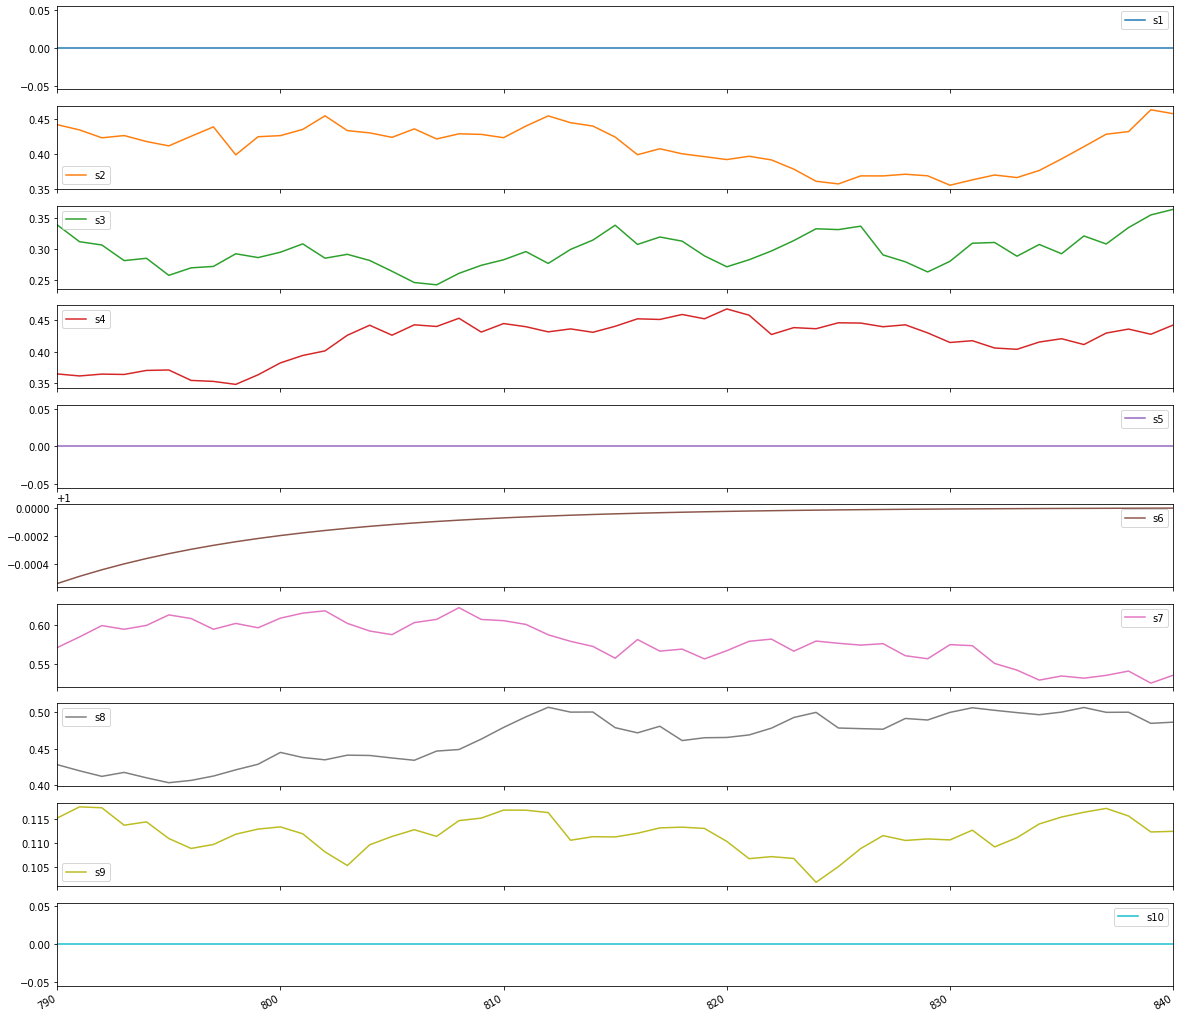

In [0]:
# plotting sensor data for engine ID 8 prior to a failure point - sensors 1-10 
ax1 = engine_id8_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

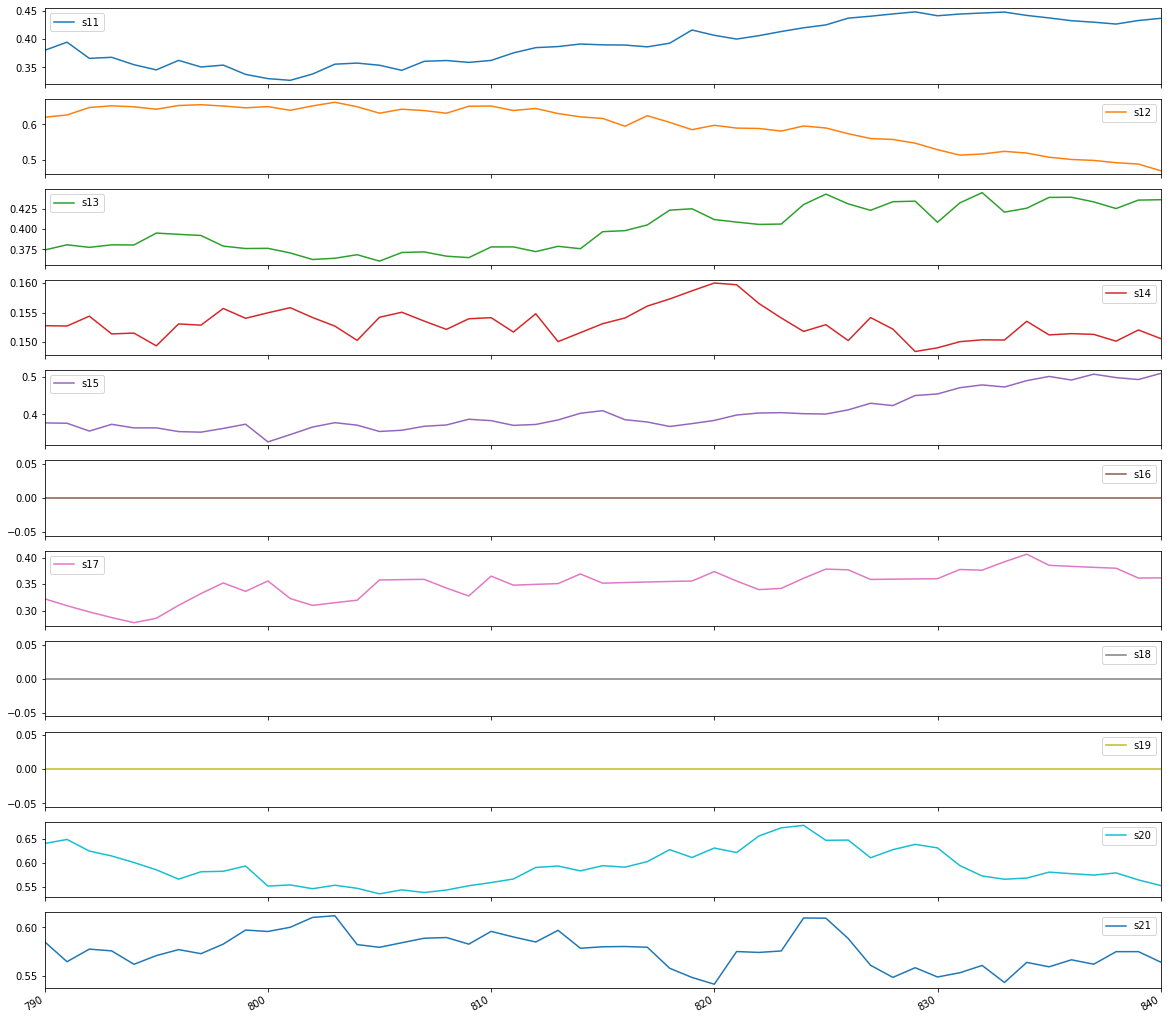

In [0]:
# plotting sensor data for engine ID 8 prior to a failure point - sensors 11-21 
ax2 = engine_id8_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

## Train and Test Sequences

In [0]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [0]:
# pick the feature columns 
# sensor_cols = ['s' + str(i) for i in range(1,22)]
# sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sensor_cols = ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
sequence_cols = ['setting1', 'setting2', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [0]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [0]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 17)

In [0]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [0]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

## Model

In [0]:
from keras.optimizers import Adam, RMSprop
from keras.layers import Input, Reshape, Dropout
from keras import Model

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(
         units=100,
         return_sequences=True,
         input_shape=(sequence_length, nb_features)))
model.add(Dropout(0.4))
model.add(LSTM(
          units=100,
          return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
model.compile(loss="mse", optimizer="rmsprop", metrics=['mse'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           47200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 127,701
Trainable params: 127,701
Non-trainable params: 0
________________________________________________

## Training the Model

In [0]:
%%time
# fit the network
hist = model.fit(seq_array, label_array, epochs=40, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 14849 samples, validate on 782 samples
Epoch 1/40





14849/14849 [==============================] - 23s 2ms/step - loss: 7905.1488 - mean_squared_error: 7905.1488 - val_loss: 7091.8519 - val_mean_squared_error: 7091.8519
Epoch 2/40
14849/14849 [==============================] - 13s 906us/step - loss: 6815.3124 - mean_squared_error: 6815.3124 - val_loss: 6215.1140 - val_mean_squared_error: 6215.1140
Epoch 3/40
14849/14849 [==============================] - 13s 869us/step - loss: 5990.1756 - mean_squared_error: 5990.1756 - val_loss: 5456.4886 - val_mean_squared_error: 5456.4886
Epoch 4/40
14849/14849 [==============================] - 13s 876us/step - loss: 5307.8204 - mean_squared_error: 5307.8204 - val_loss: 4808.2443 - val_mean_squared_error: 4808.2443
Epoch 5/40
14849/14849 [==============================] - 13s 855us/step - loss: 4690.1499 - mean_squared_error: 4690.1499 - val

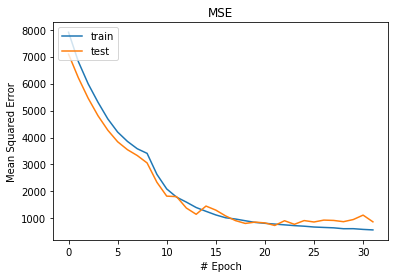

In [0]:
plt.plot(hist.history['mean_squared_error'])
plt.plot(hist.history['val_mean_squared_error'])
plt.title('MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('# Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Results on Train Set

In [0]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('MSE: {}'.format(scores[1]))

15631/15631 [==============================] - 5s 322us/step
MSE: 516.7211913367424


## Results on Test Set

In [0]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 17)

In [0]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [0]:
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [0]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 17)
(93, 1)


In [0]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('MSE: {}'.format(scores_test[1]))

MSE: 511.0433382423975


In [0]:
results_df = pd.DataFrame([[scores_test[1]],],
                         columns = ['MSE'],
                         index = ['LSTM'])
results_df

,MSE
LSTM,511.043338


## Plot of Predictions vs True RUL Values

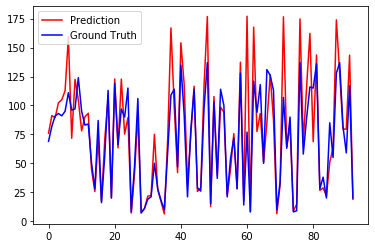

In [0]:
y_pred_test = model.predict(seq_array_test_last, verbose=0)

import matplotlib.pyplot as plt2

plt2.plot(y_pred_test, color='red', label='Prediction')
plt2.plot(label_array_test_last, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()